# 1. Import Libraries

In [34]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

import seaborn as sns
import matplotlib.pyplot as plt

# 2. Import Dataset

Source of Dataset= https://www.kaggle.com/wenruliu/adult-income-dataset

In this case I want to predict whether income exceeds $50K/yr based on census data.

In [35]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# 3. Exploratory Data Analysis

### Renaming columns

In [36]:
for col in df.columns:
    df.rename(columns={col:col.replace('-','_')}, inplace=True)

In [37]:
df.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Update value in the target column

In [38]:
df.income.unique()

array(['<=50K', '>50K'], dtype=object)

In [39]:
df['income'] = df.income.map({'<=50K':0, '>50K':1})

### Data Information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   48842 non-null  object
 14  income           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [8]:
df.shape

(48842, 15)

### Data Description

In [9]:
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week,income
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [10]:
df.describe(include='O')

,workclass,education,marital_status,occupation,relationship,race,gender,native_country
count,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33906,15784,22379,6172,19716,41762,32650,43832


### Replace value within columns

In [11]:
df.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [12]:
df.workclass.unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [13]:
df.occupation.unique()

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [14]:
df.native_country.unique()

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

In [15]:
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native_country'] = df['native_country'].replace('?', np.nan)

`In this part, I replace the value of the column that has '?' into 'nan' or we can call that is a missing value. And then, the missing value can be handled by imputing the value by default with 'Median' for numerical and 'Most_frequent' for categorical in Pipeline.`

### Check Missing Value

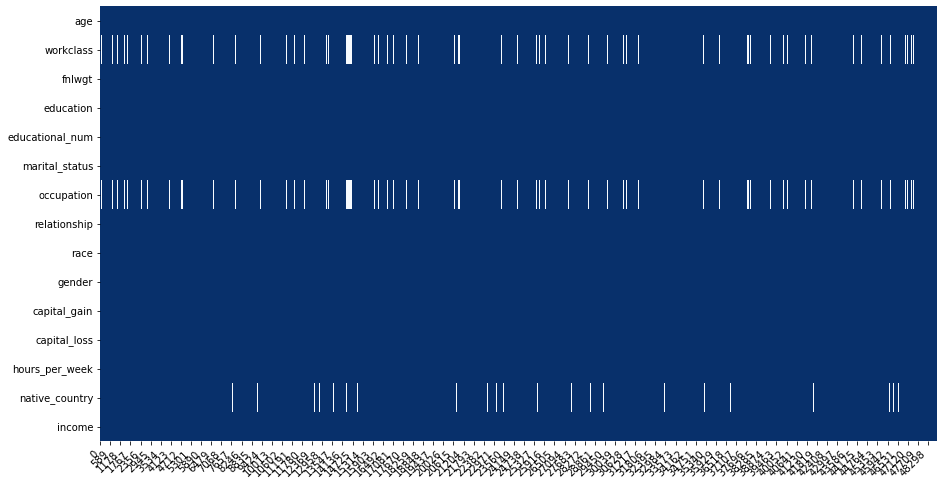

In [16]:
plot_missing_value(df)

`Missing value can be handled in Pipeline.`

## A. Numerical Features

In [17]:
numeric = df.select_dtypes(include=[np.number])
numeric

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week,income
0,25,226802,7,0,0,40,0
1,38,89814,9,0,0,50,0
2,28,336951,12,0,0,40,1
3,44,160323,10,7688,0,40,1
4,18,103497,10,0,0,30,0
...,...,...,...,...,...,...,...
48837,27,257302,12,0,0,38,0
48838,40,154374,9,0,0,40,1
48839,58,151910,9,0,0,40,0
48840,22,201490,9,0,0,20,0


### Boxplot

------------------ AGE ------------------


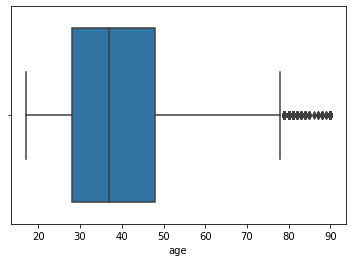

------------------ FNLWGT ------------------


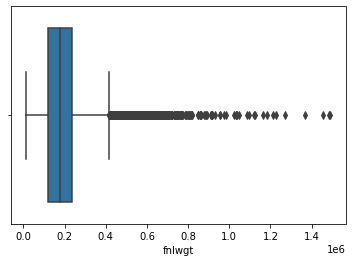

------------------ EDUCATIONAL_NUM ------------------


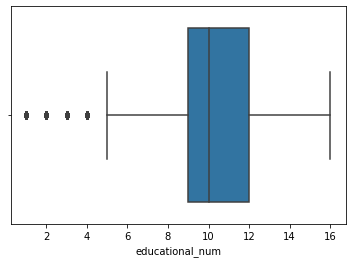

------------------ CAPITAL_GAIN ------------------


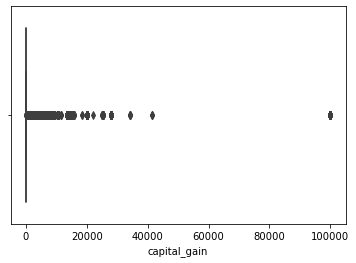

------------------ CAPITAL_LOSS ------------------


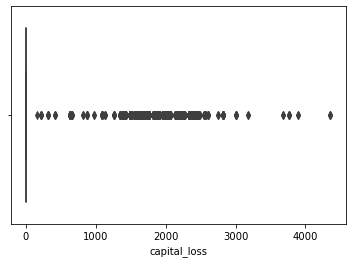

------------------ HOURS_PER_WEEK ------------------


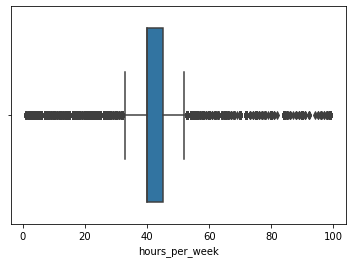

------------------ INCOME ------------------


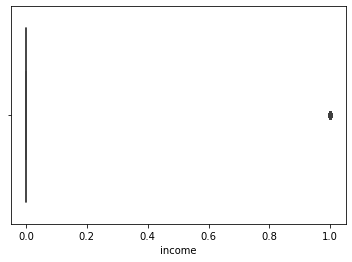

In [18]:
for col in numeric:
    print ('------------------',col.upper(),'------------------')
    sns.boxplot(x = df[col], data=df)
    plt.show()

`Despite of many columns has outliers, I don't handle them yet because the values might supposed to be like that.`

### Numerical Distribution

------------------ AGE ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


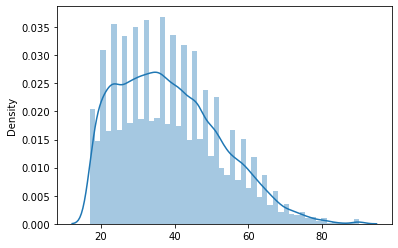

------------------ FNLWGT ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


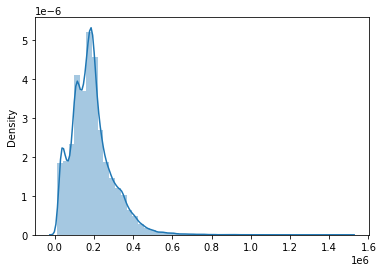

------------------ EDUCATIONAL_NUM ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


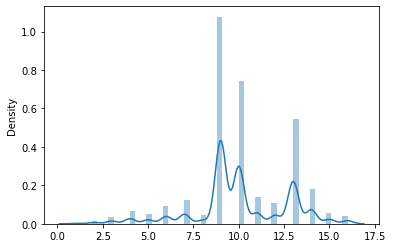

------------------ CAPITAL_GAIN ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


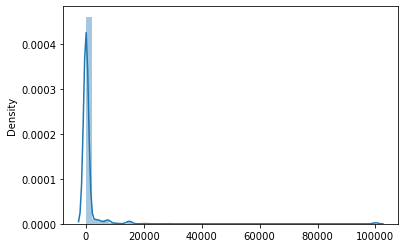

------------------ CAPITAL_LOSS ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


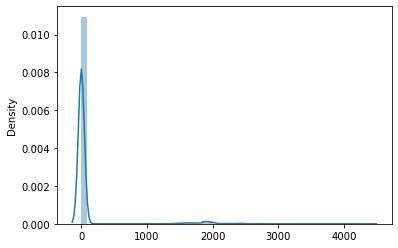

------------------ HOURS_PER_WEEK ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


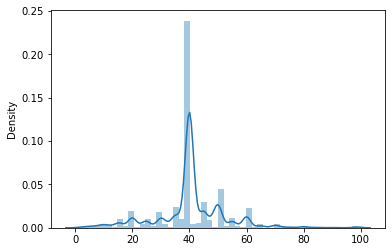

------------------ INCOME ------------------


C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


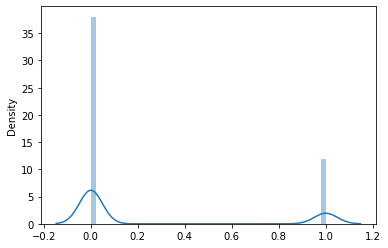

In [19]:
for col in numeric:
    print ('------------------',col.upper(),'------------------')
    sns.distplot(x = df[col])
    plt.show()

## Numeric vs Target

### Boxplot

------------------ AGE ------------------


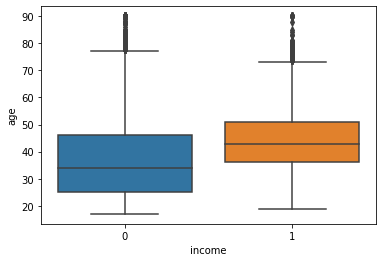

------------------ FNLWGT ------------------


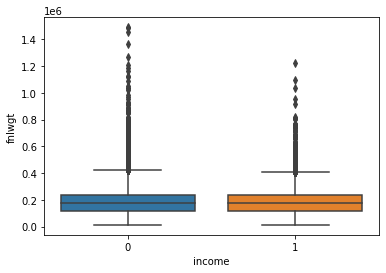

------------------ EDUCATIONAL_NUM ------------------


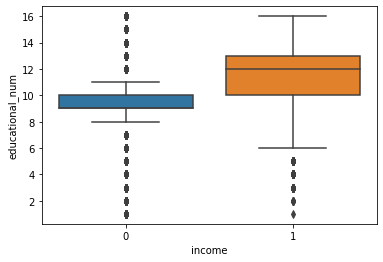

------------------ CAPITAL_GAIN ------------------


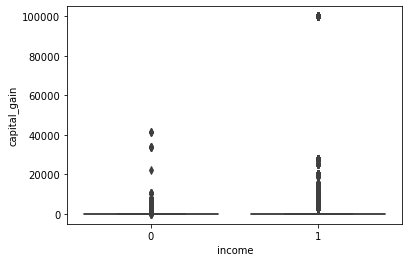

------------------ CAPITAL_LOSS ------------------


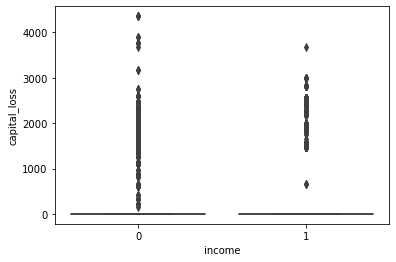

------------------ HOURS_PER_WEEK ------------------


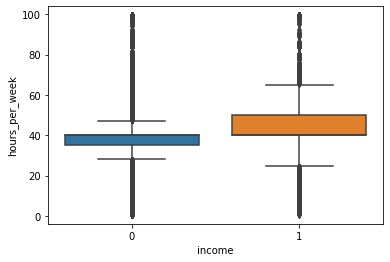

------------------ INCOME ------------------


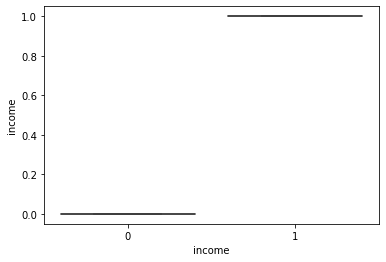

In [20]:
for col in numeric:
    print ('------------------',col.upper(),'------------------')
    sns.boxplot(x= 'income', y = df[col], data=df)
    plt.show()

### Features Distribution by income

In [21]:
df.income.unique()

array([0, 1], dtype=int64)

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


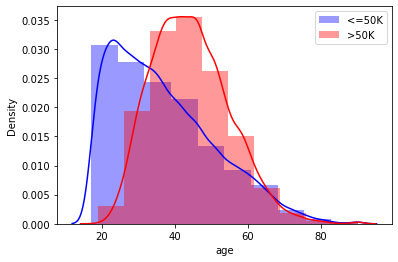

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


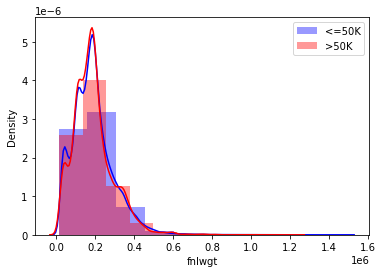

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


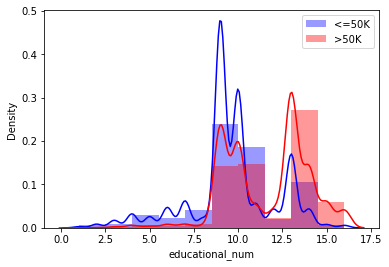

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


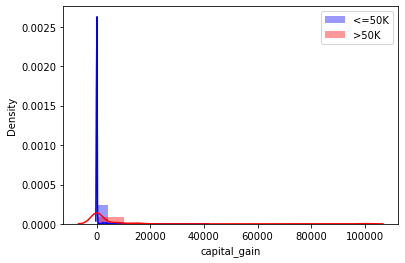

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


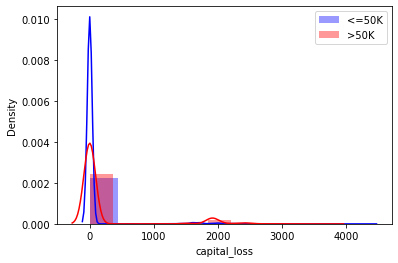

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


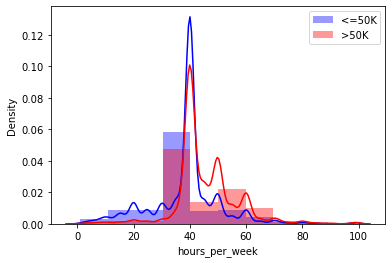

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Malik Afu Hamid\anaconda3\li

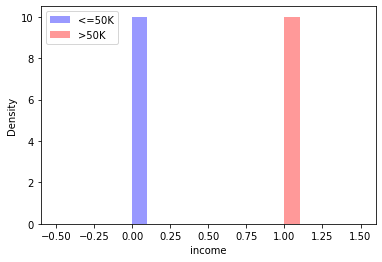

In [22]:
for col in numeric:
    sns.distplot(df[col][df.income == 0], bins = 10, label = '<=50K', color = 'b')
    sns.distplot(df[col][df.income == 1], bins = 10, label = '>50K', color = 'r')
    plt.legend()
    plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~ AGE ~~~~~~~~~~~~~~~~~~~~~~~~~


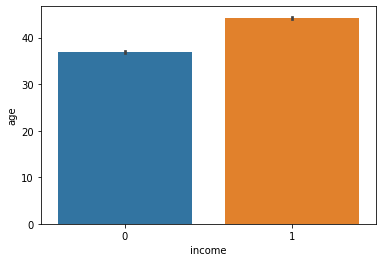

~~~~~~~~~~~~~~~~~~~~~~~~~ FNLWGT ~~~~~~~~~~~~~~~~~~~~~~~~~


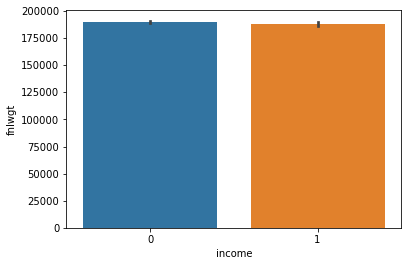

~~~~~~~~~~~~~~~~~~~~~~~~~ EDUCATIONAL_NUM ~~~~~~~~~~~~~~~~~~~~~~~~~


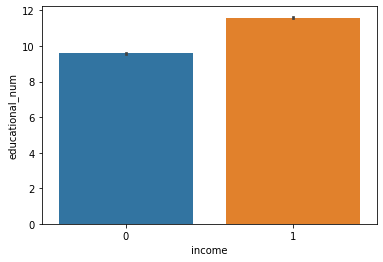

~~~~~~~~~~~~~~~~~~~~~~~~~ CAPITAL_GAIN ~~~~~~~~~~~~~~~~~~~~~~~~~


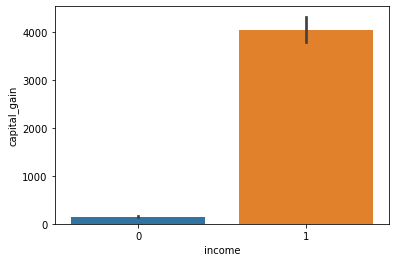

~~~~~~~~~~~~~~~~~~~~~~~~~ CAPITAL_LOSS ~~~~~~~~~~~~~~~~~~~~~~~~~


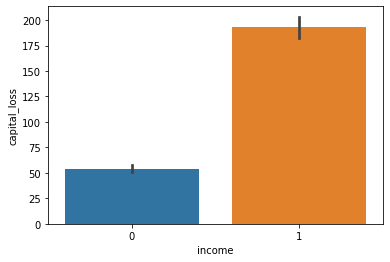

~~~~~~~~~~~~~~~~~~~~~~~~~ HOURS_PER_WEEK ~~~~~~~~~~~~~~~~~~~~~~~~~


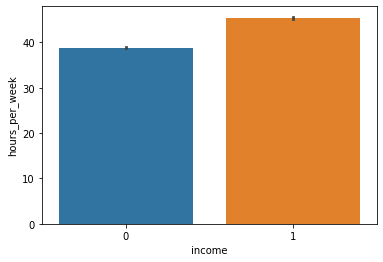

~~~~~~~~~~~~~~~~~~~~~~~~~ INCOME ~~~~~~~~~~~~~~~~~~~~~~~~~


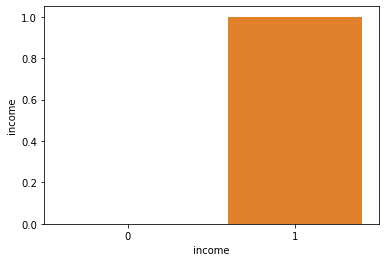

In [23]:
for i in numeric:
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~',i.upper(),'~~~~~~~~~~~~~~~~~~~~~~~~~')
    sns.barplot(x='income', y=df[i], data=df)
    plt.show()

## Correlation Ratio

In [24]:
from jcopml.plot import plot_correlation_ratio

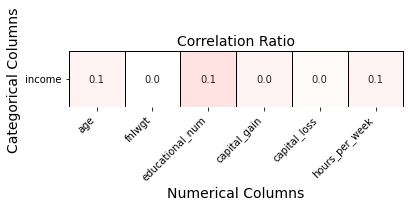

In [25]:
plot_correlation_ratio(df, catvar=['income'], numvar=['age','fnlwgt','educational_num','capital_gain','capital_loss','hours_per_week'], report=False)

## B. Categorical Features

In [26]:
categoric = df.select_dtypes(include=[np.object])

C:\Users\MALIKA~1\AppData\Local\Temp/ipykernel_82684/145167230.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoric = df.select_dtypes(include=[np.object])


In [27]:
categoric

,workclass,education,marital_status,occupation,relationship,race,gender,native_country
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
4,NaN,Some-college,Never-married,NaN,Own-child,White,Female,United-States
...,...,...,...,...,...,...,...,...
48837,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States
48838,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
48839,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States
48840,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States


### Categorical Distribution

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C

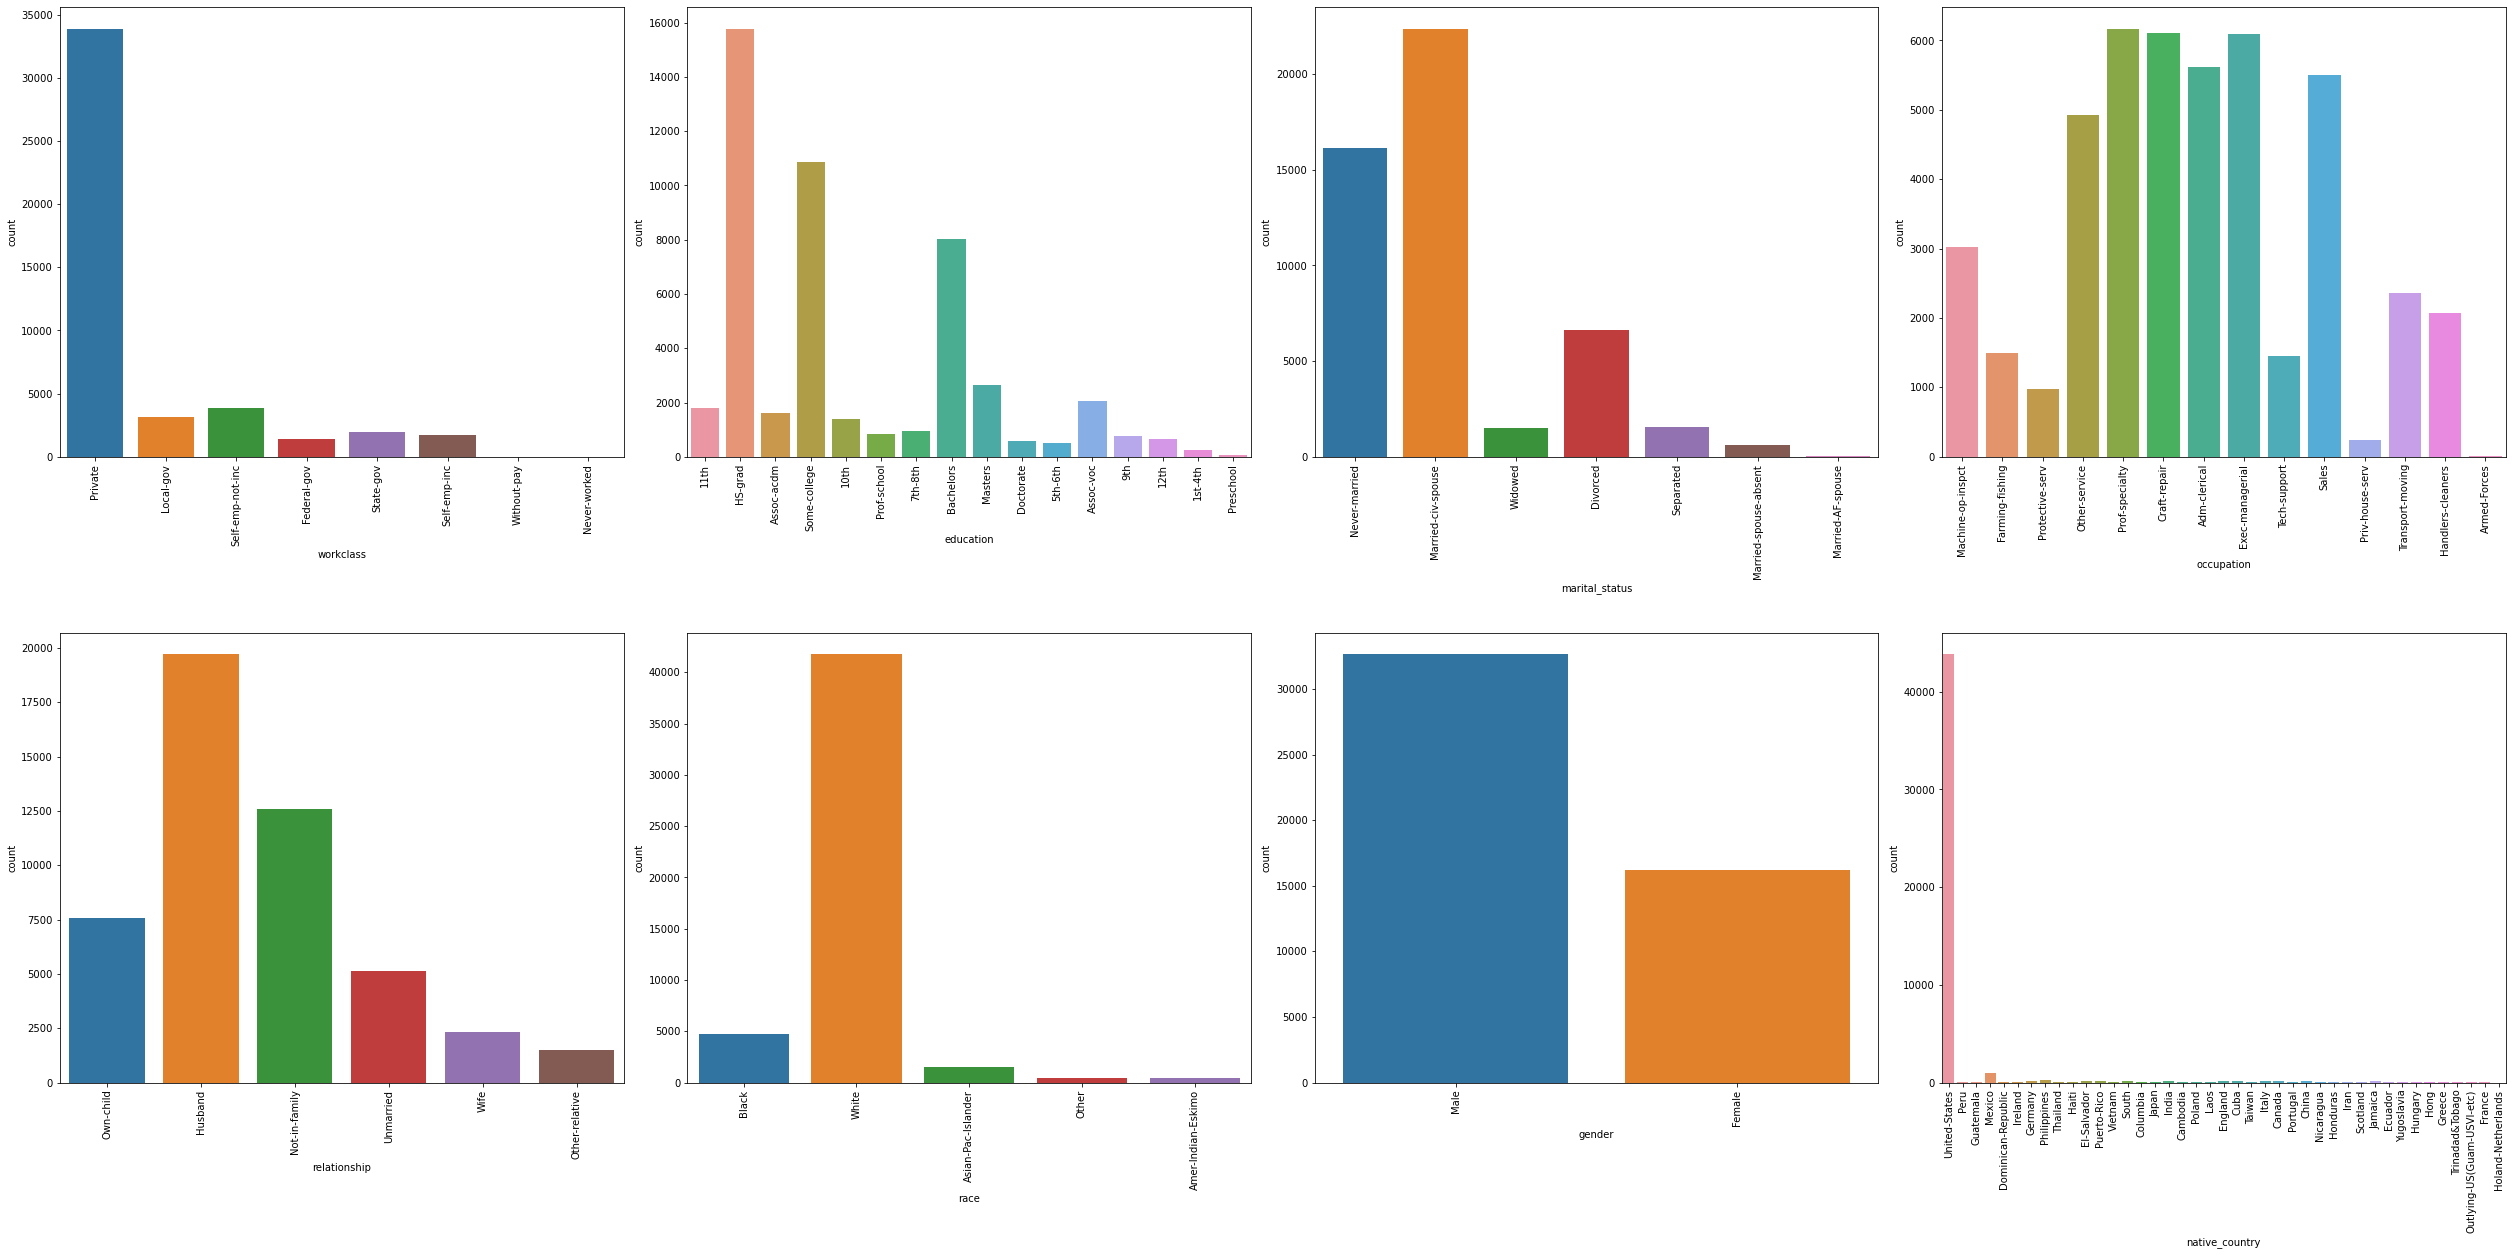

In [28]:
canvas = plt.figure(figsize=(35, 50))

for i, j in enumerate(categoric):
    canvas.add_subplot(6, 4, i+1)
    plot = sns.countplot(df[j])
    plt.setp(plot.get_xticklabels(), rotation=90)
    canvas.tight_layout()

### Categorical distribution based on income

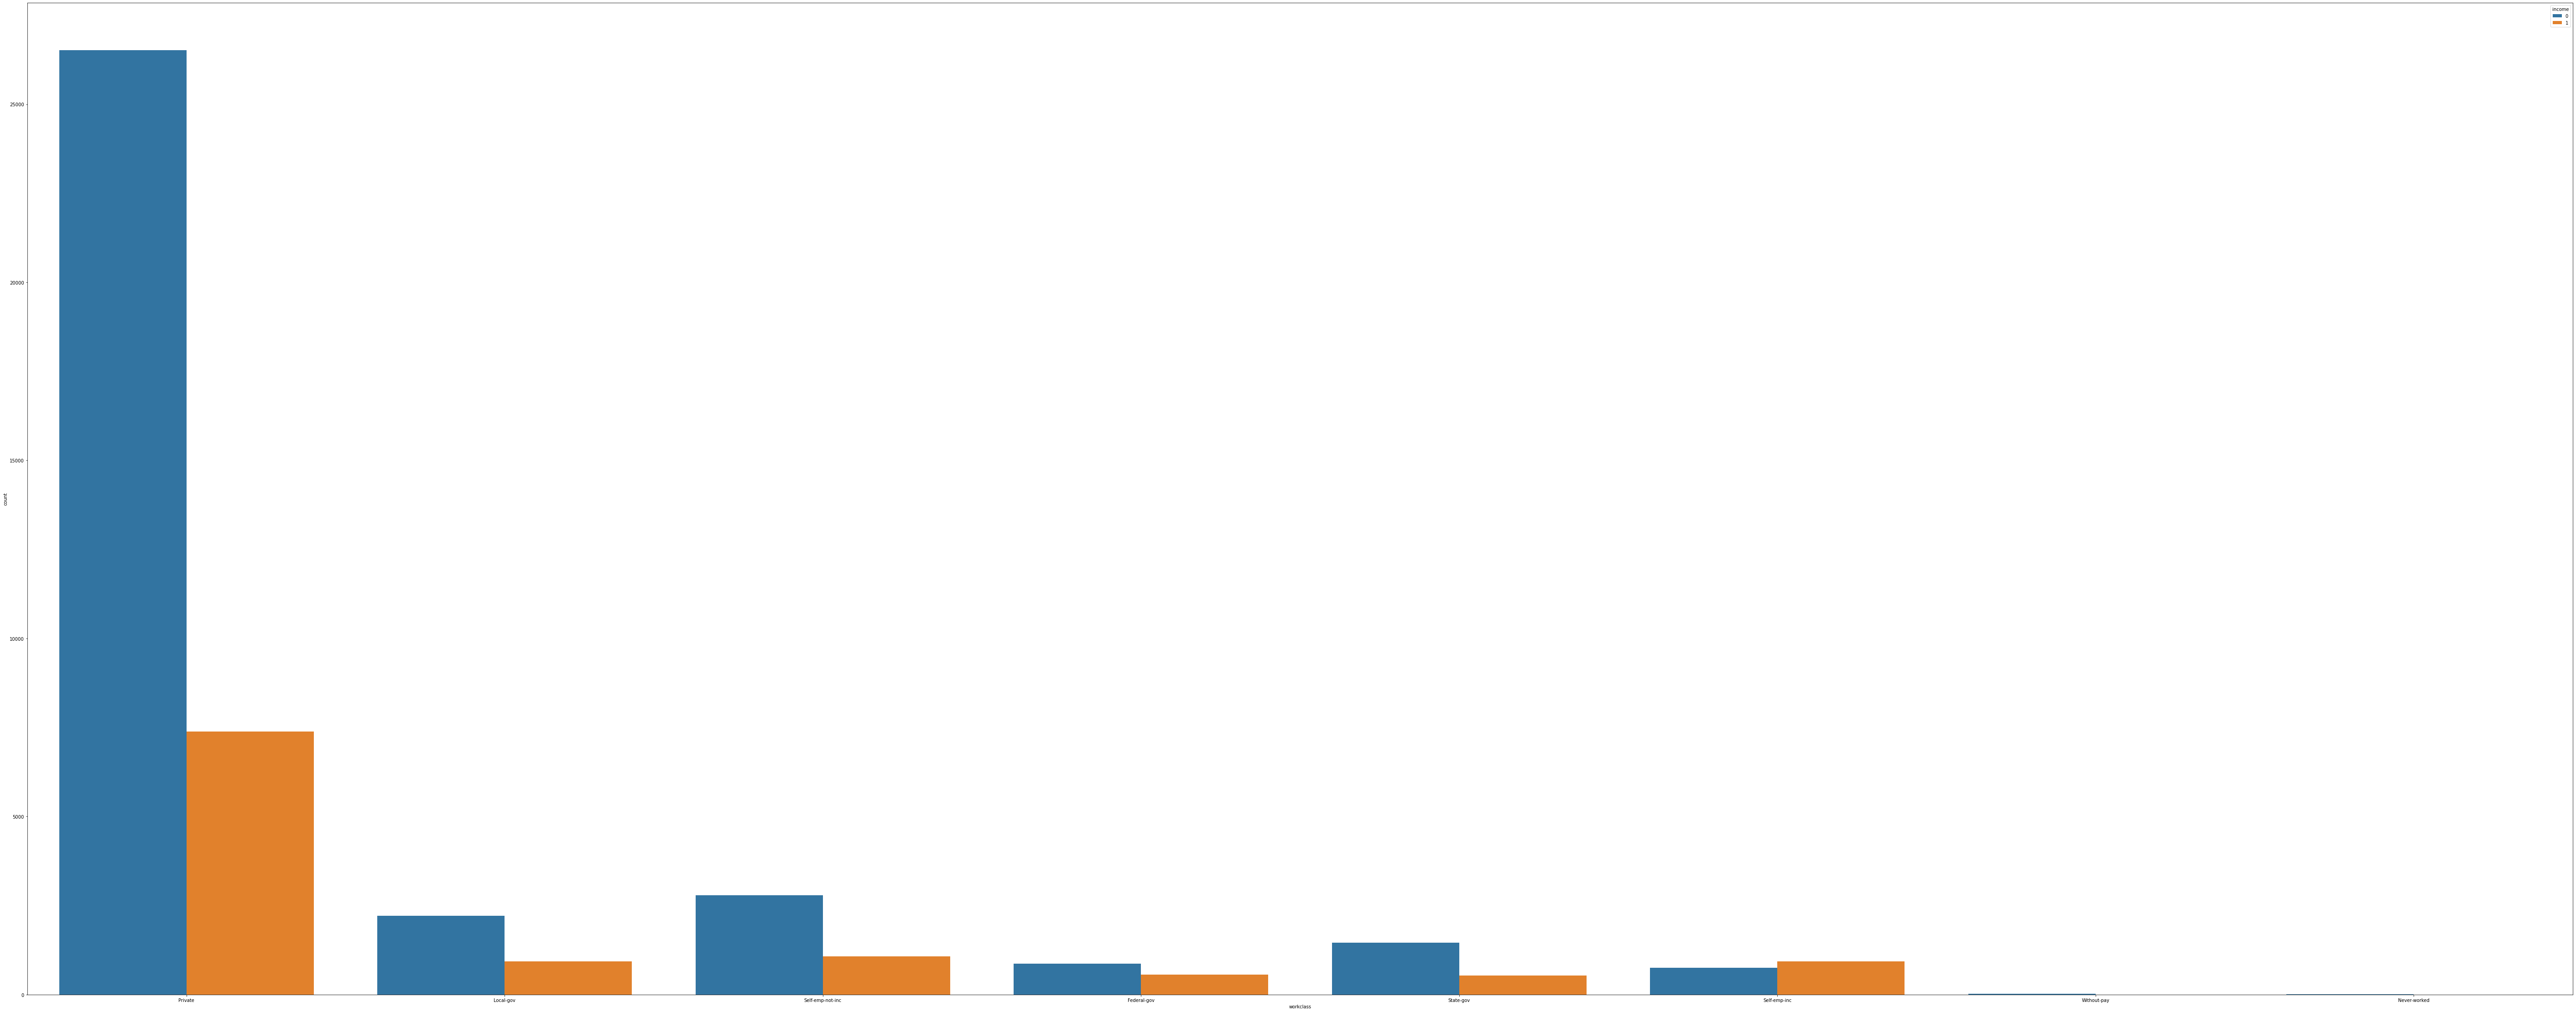

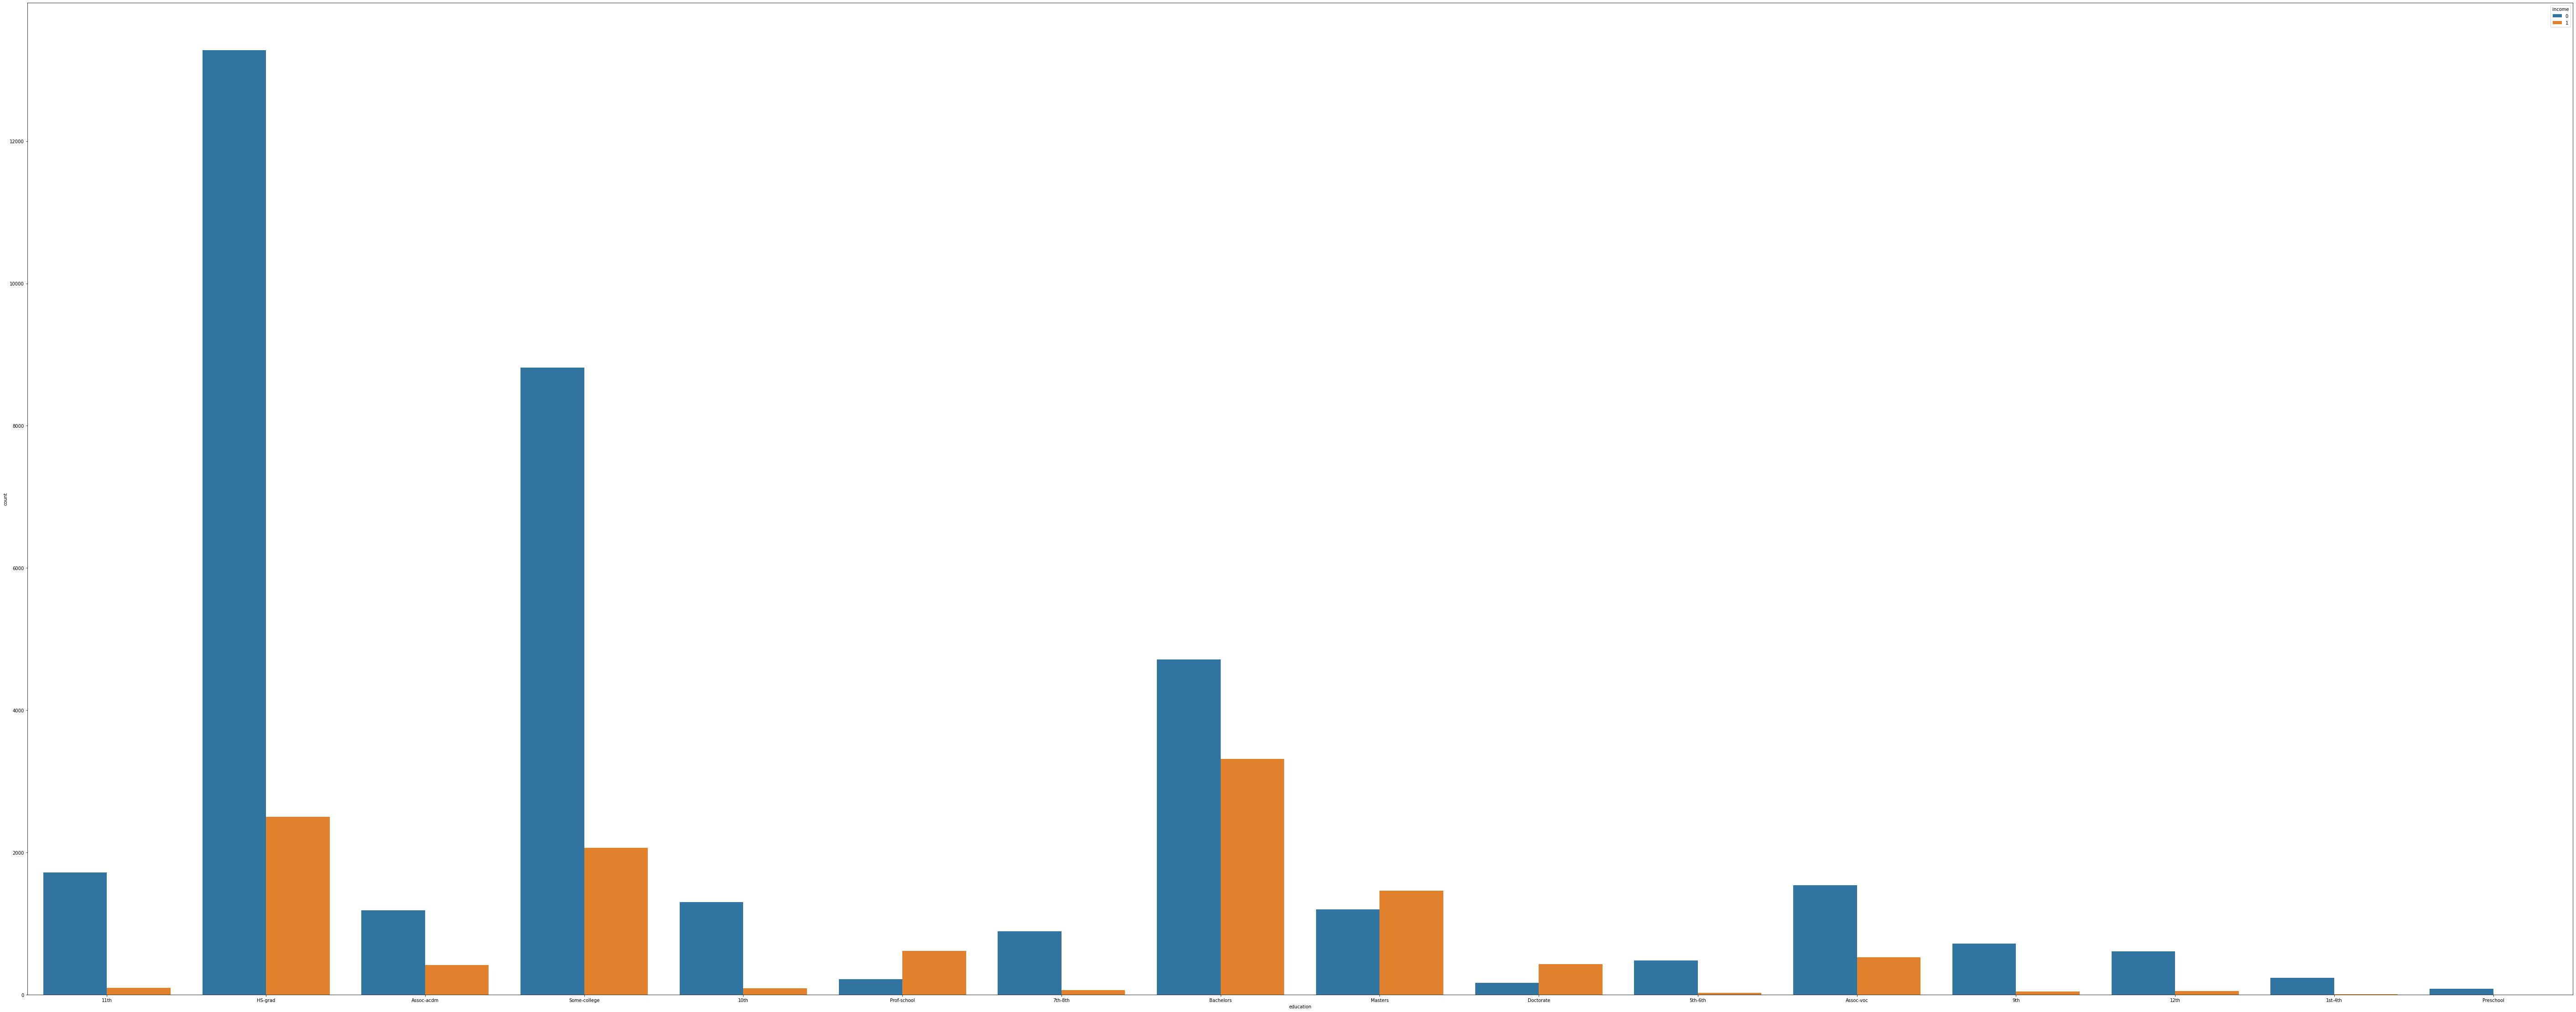

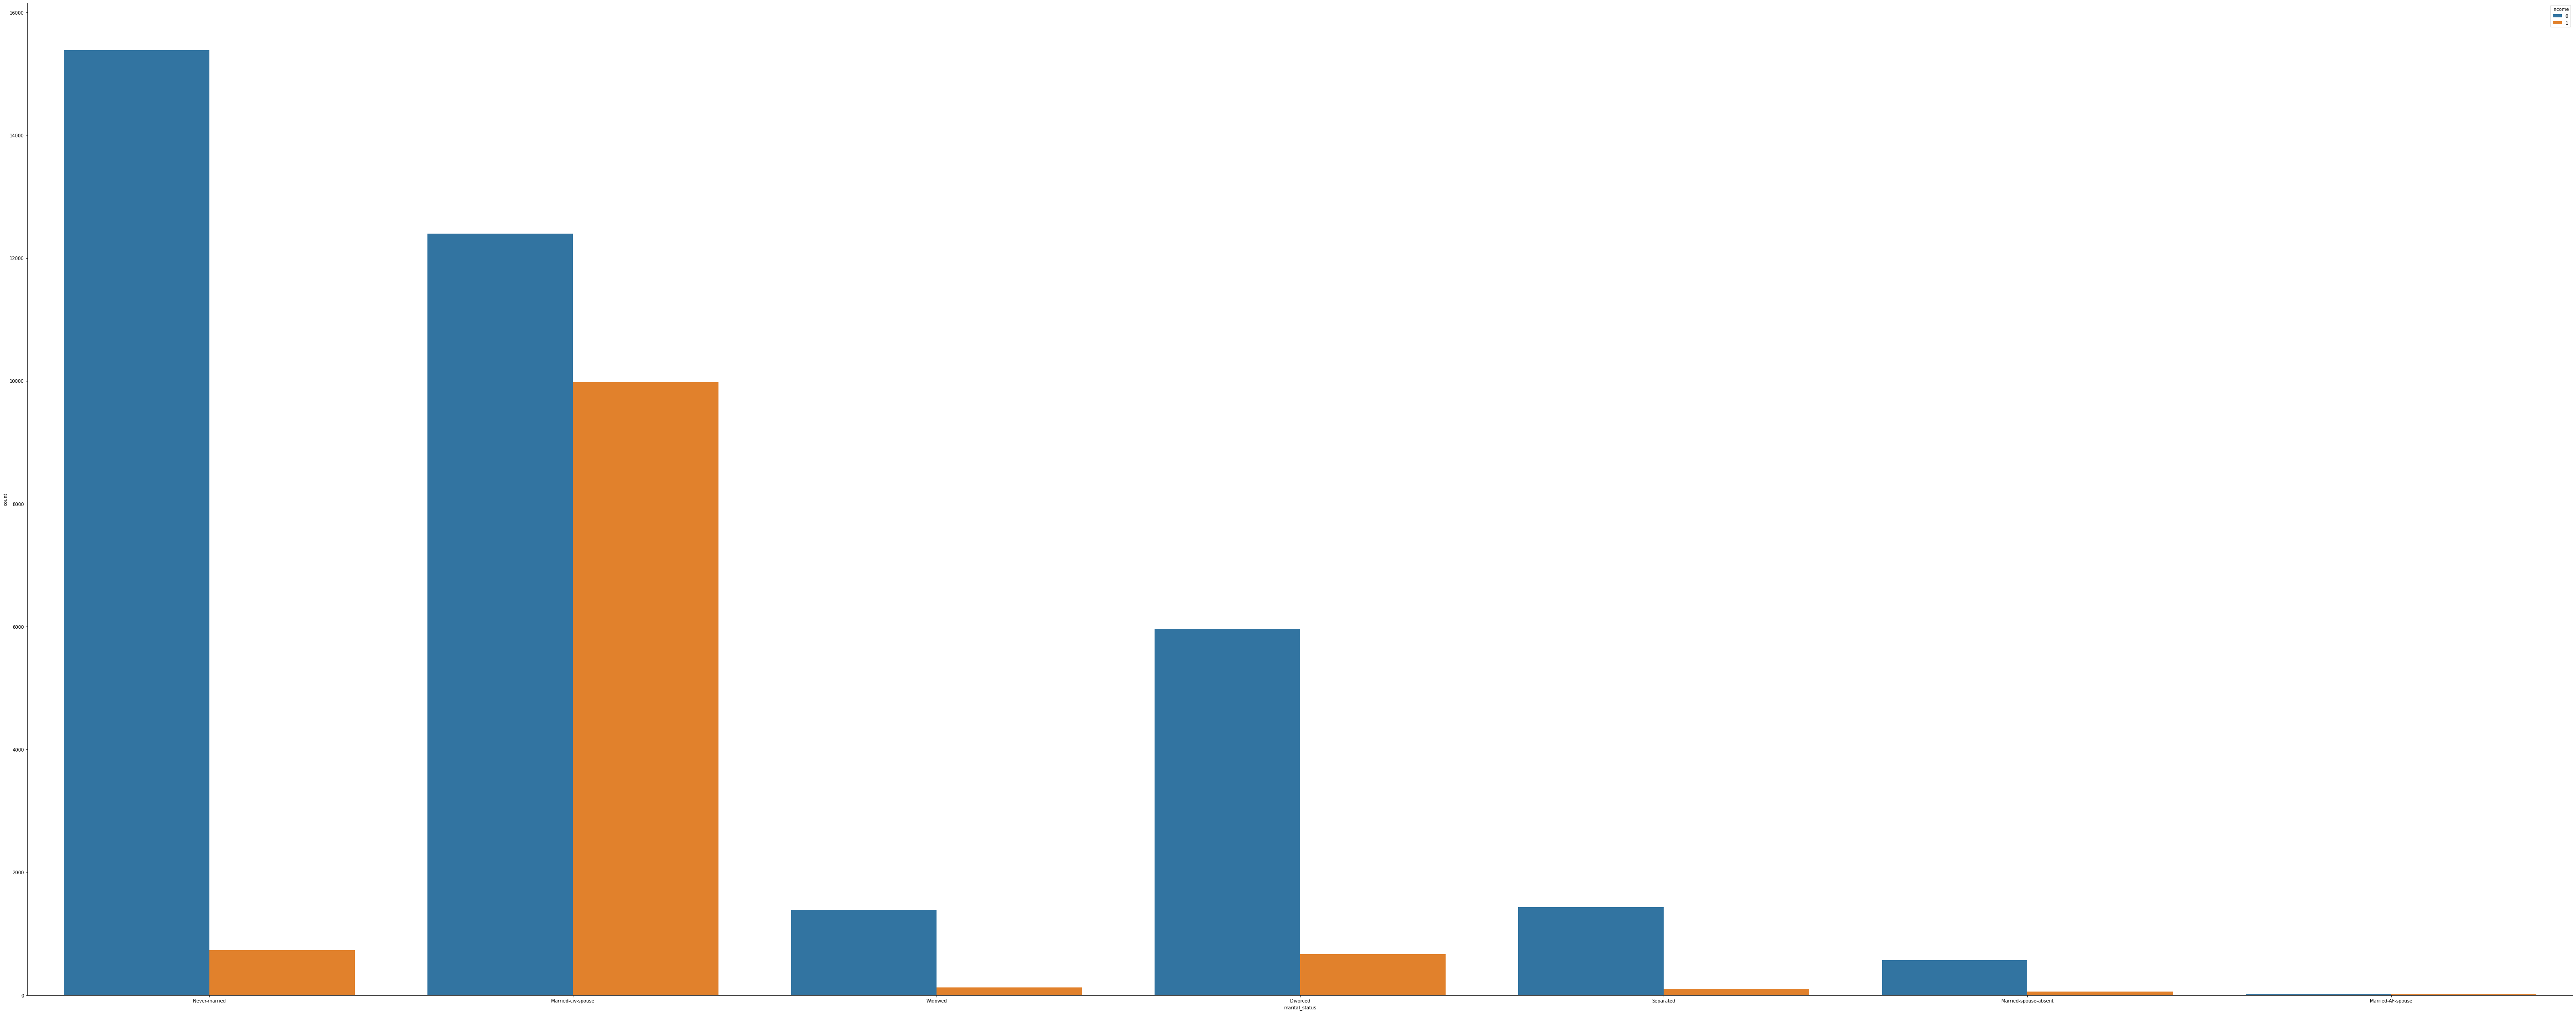

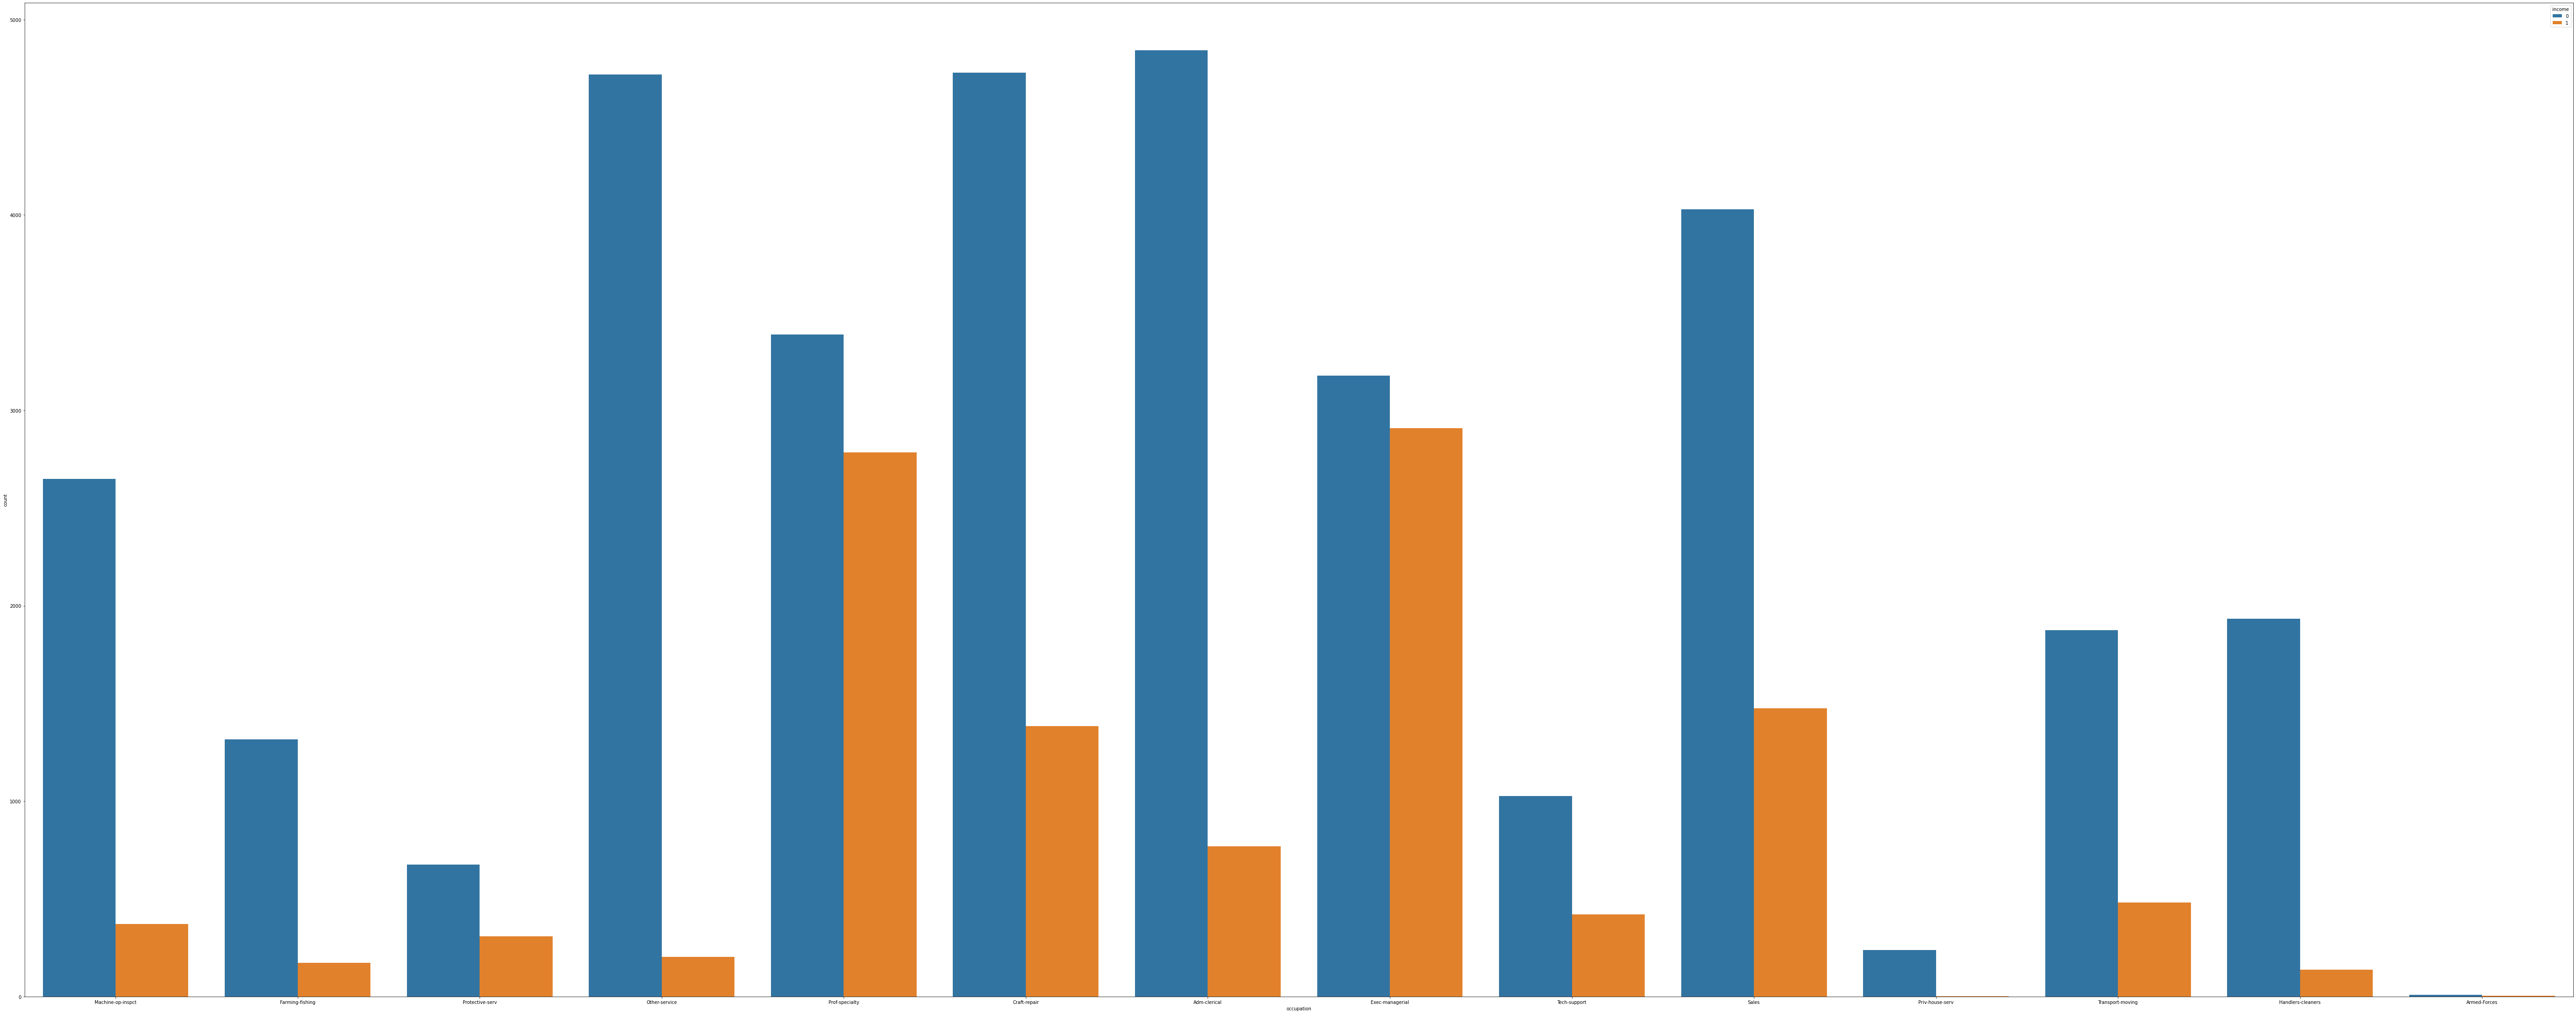

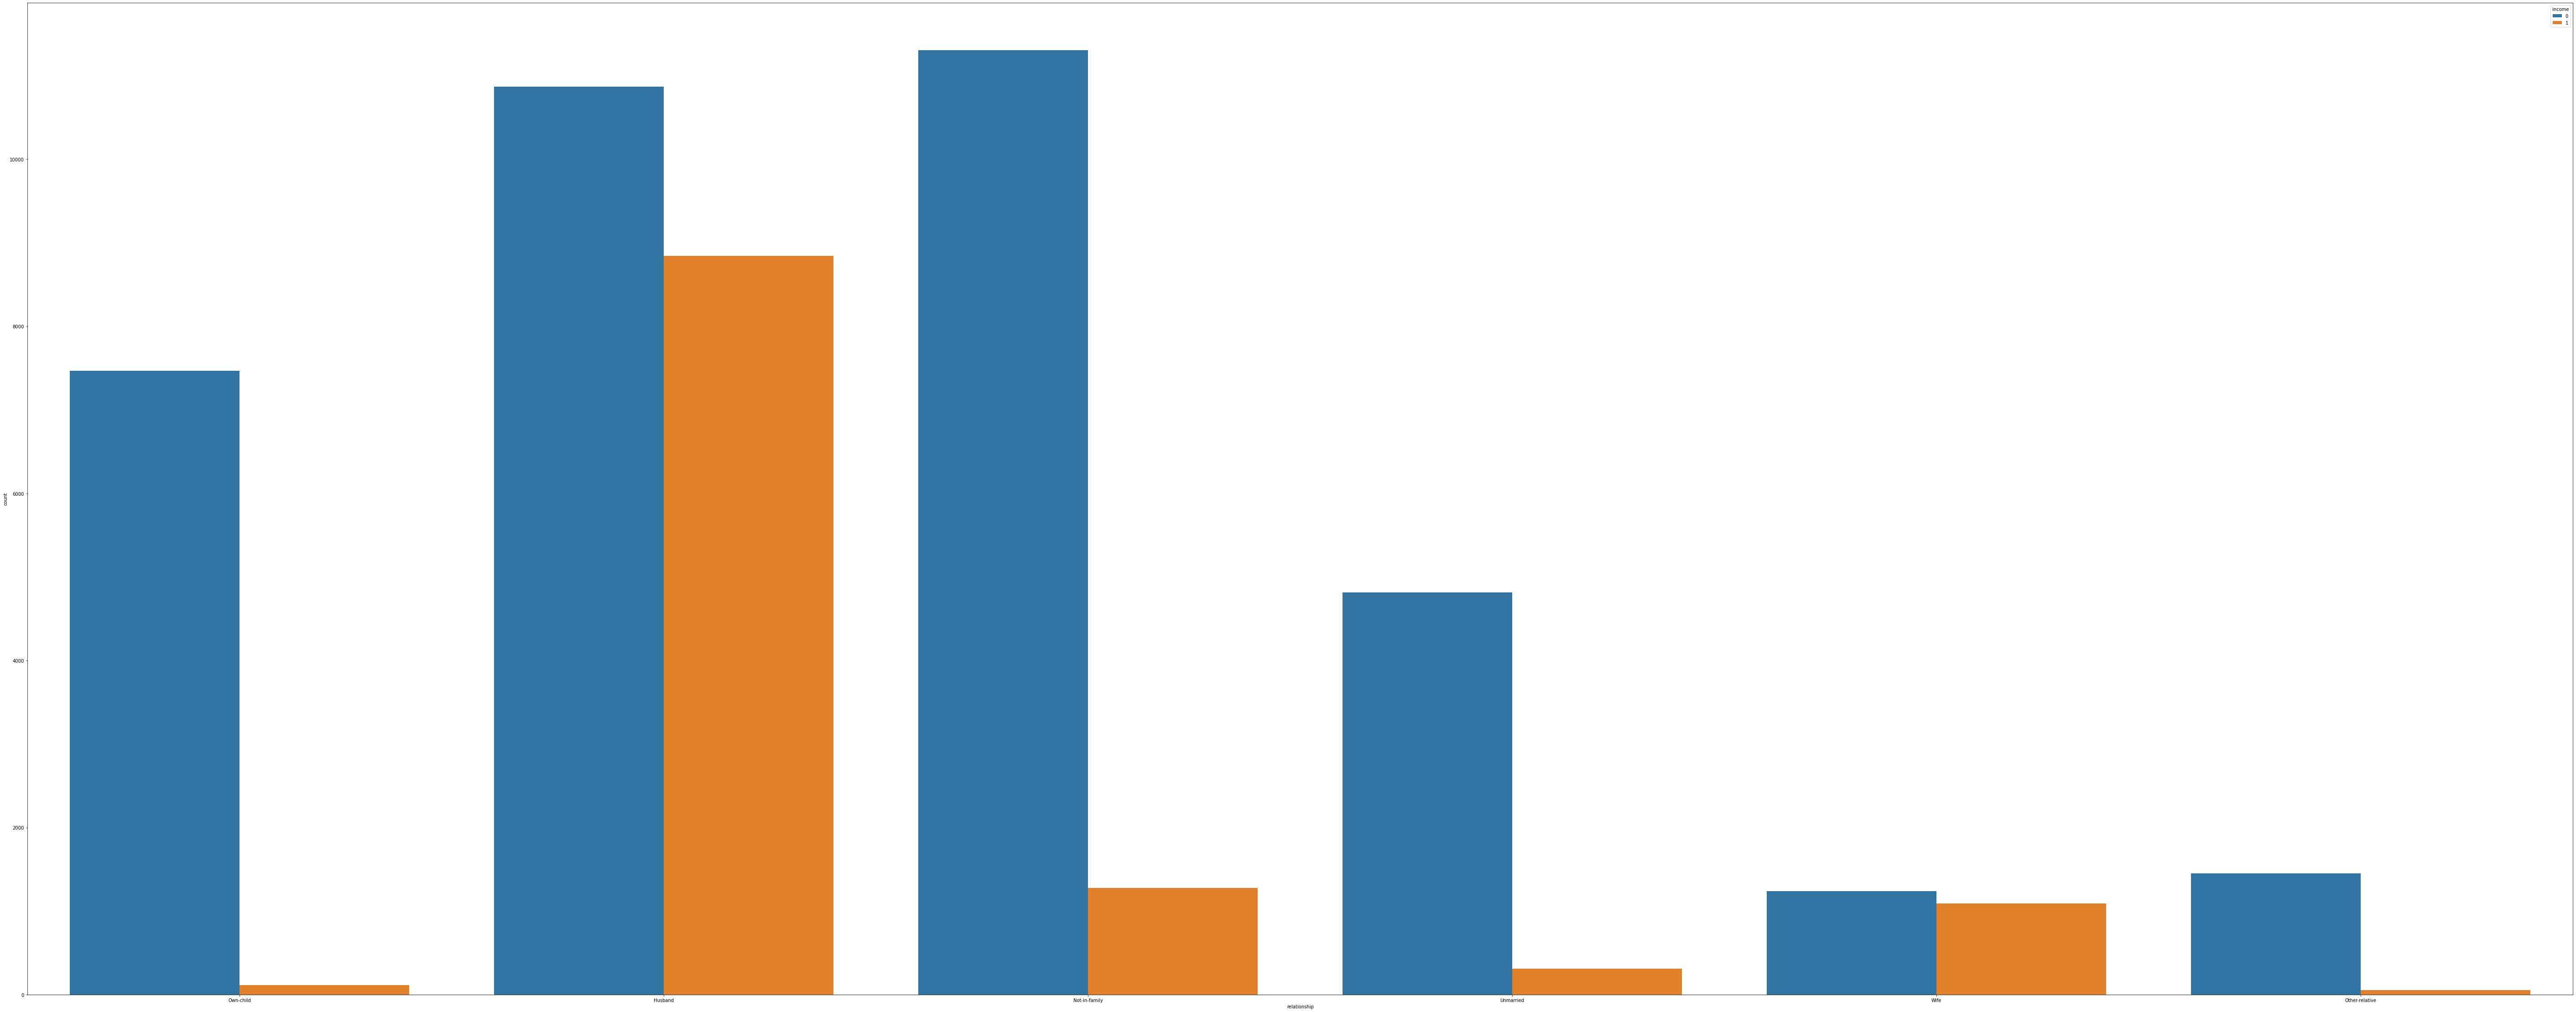

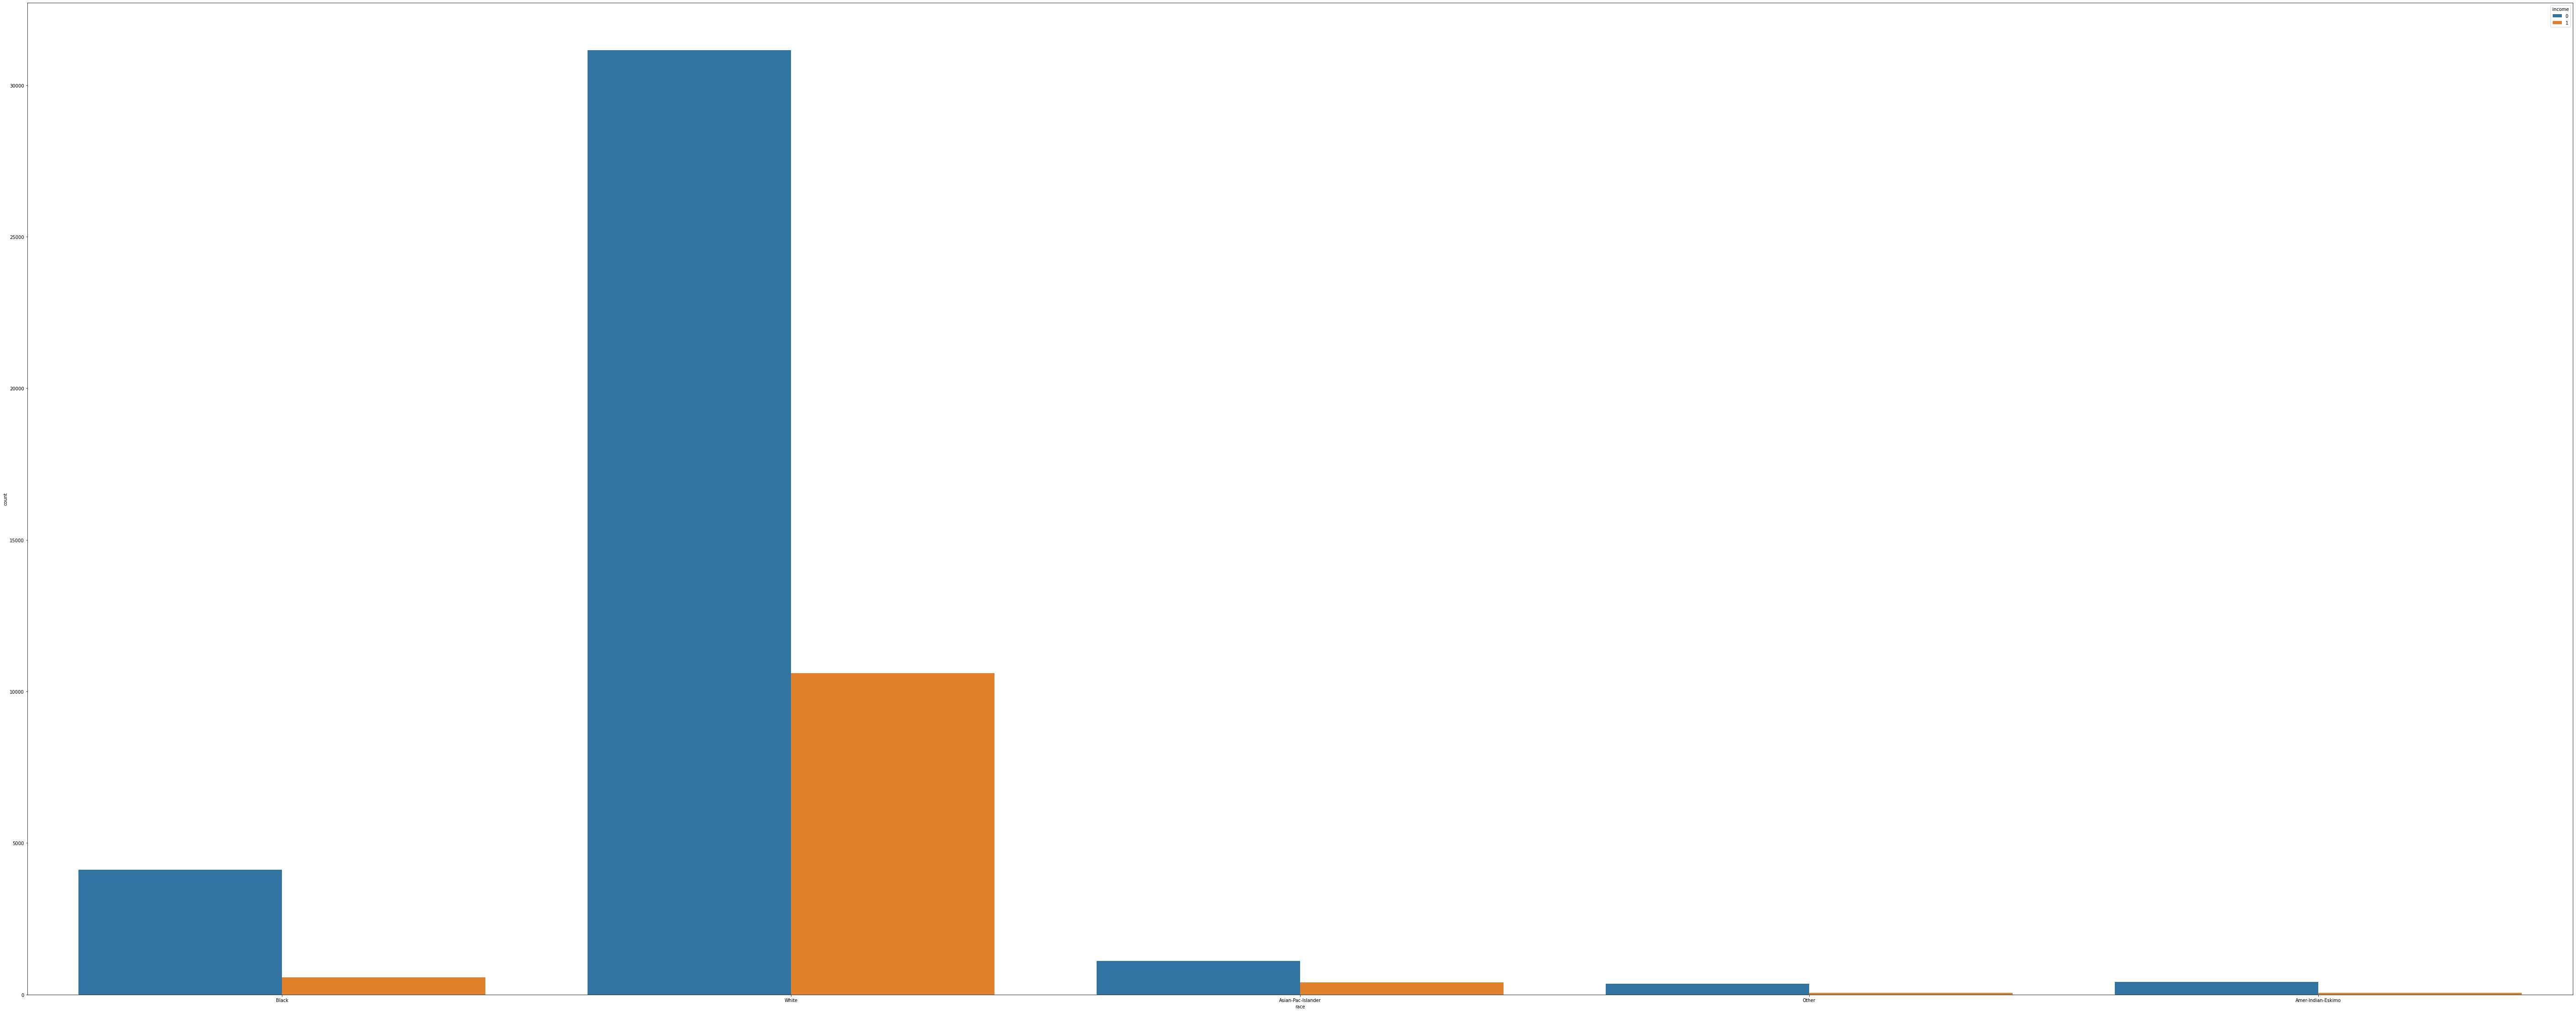

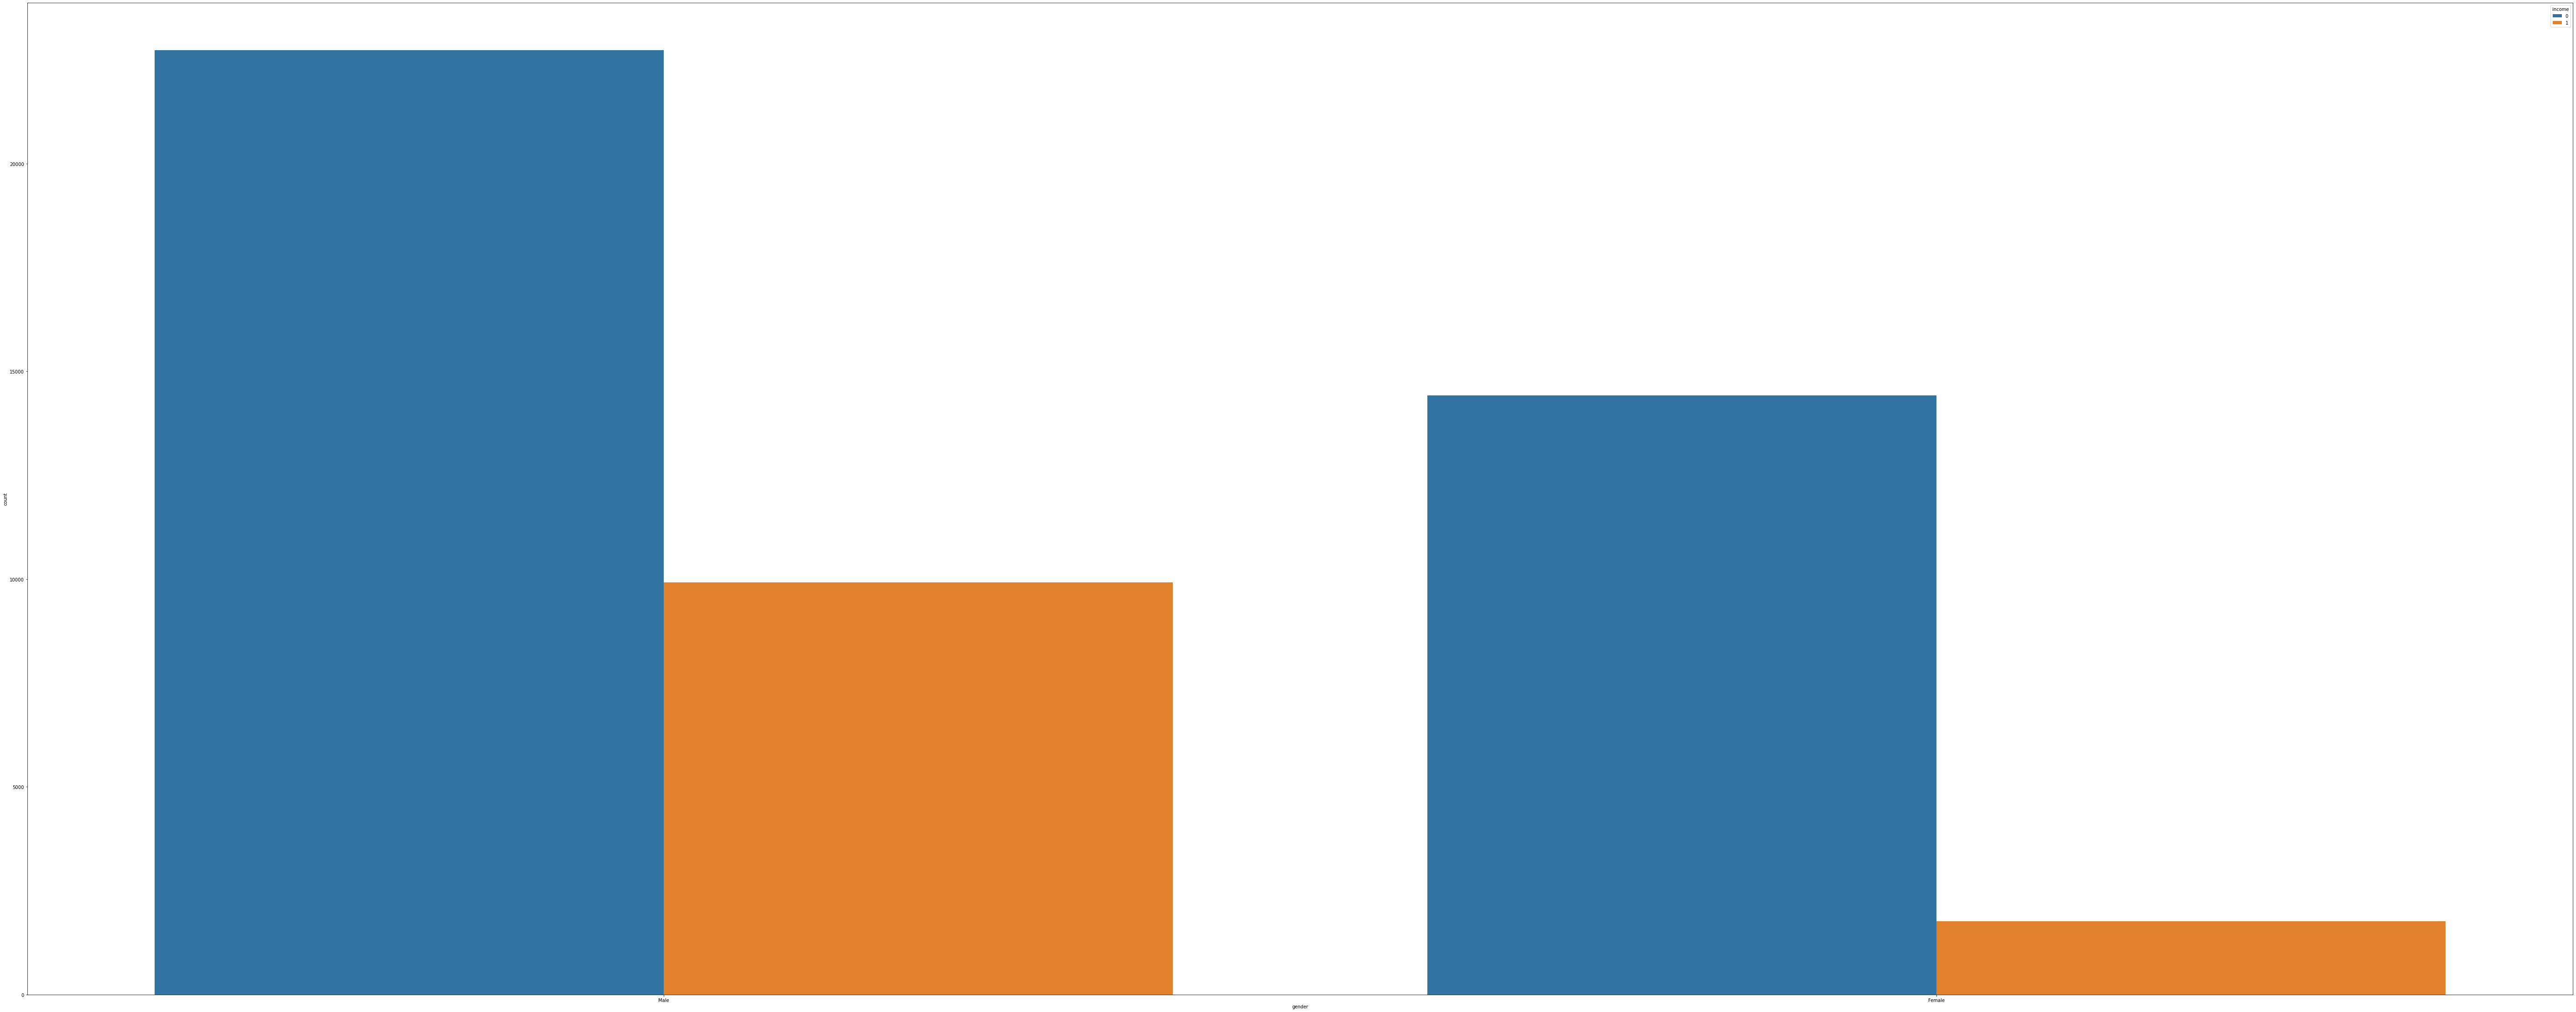

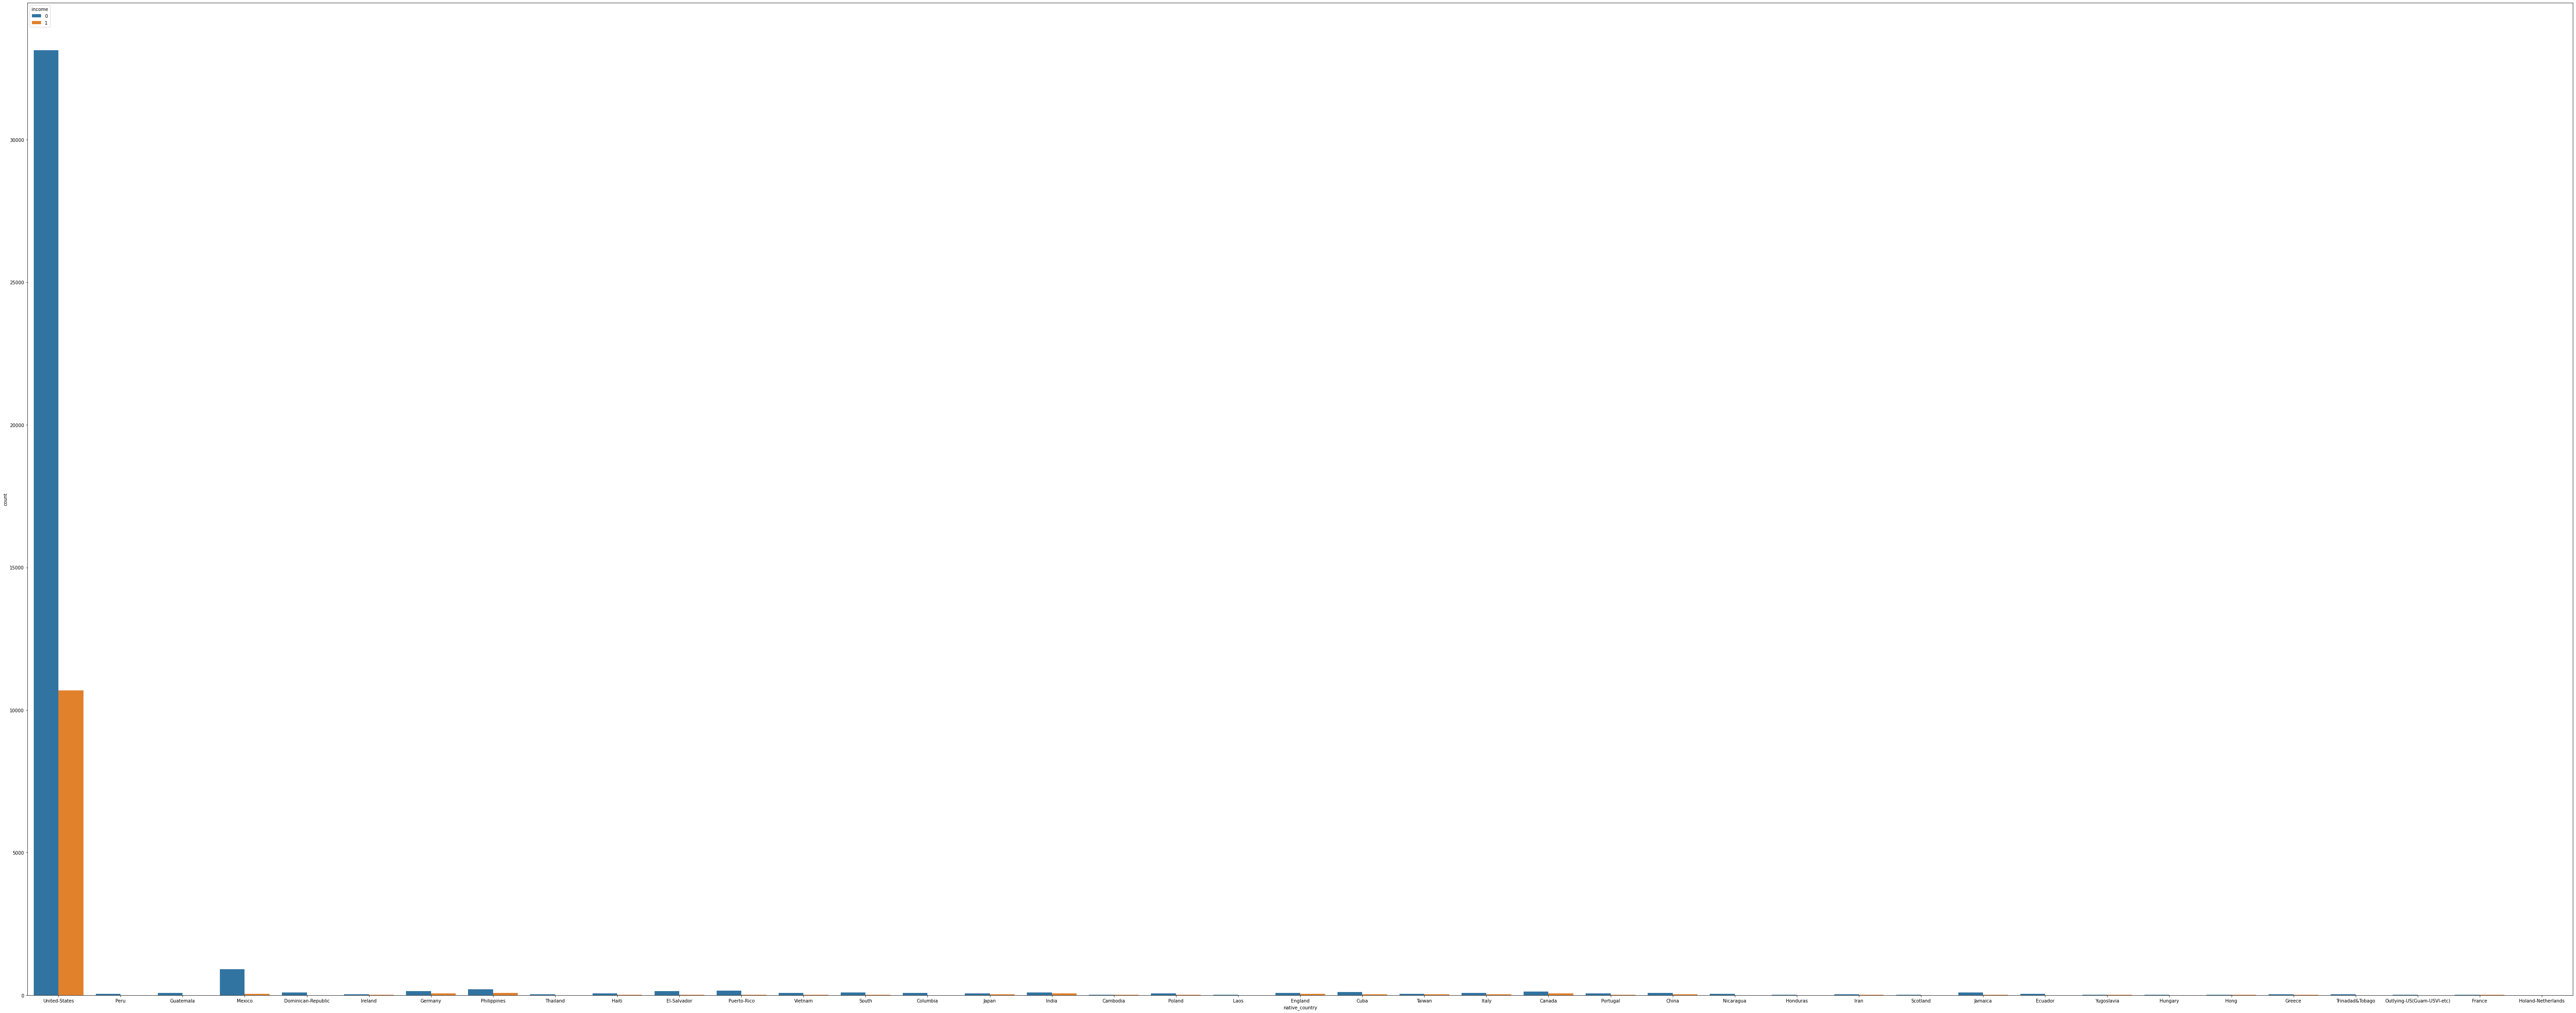

In [29]:
for col in categoric:
    plt.figure(figsize=(100,40))
    sns.countplot(x= df[col], data=df, hue='income')
    plt.show()

`I set width so high because the column of native_country has a long character.`

### Association Matrix (categoric vs categoric)

In [30]:
from jcopml.plot import plot_association_matrix

In [31]:
plot_association_matrix(df, target_col='income', categoric_col=list(categoric))

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

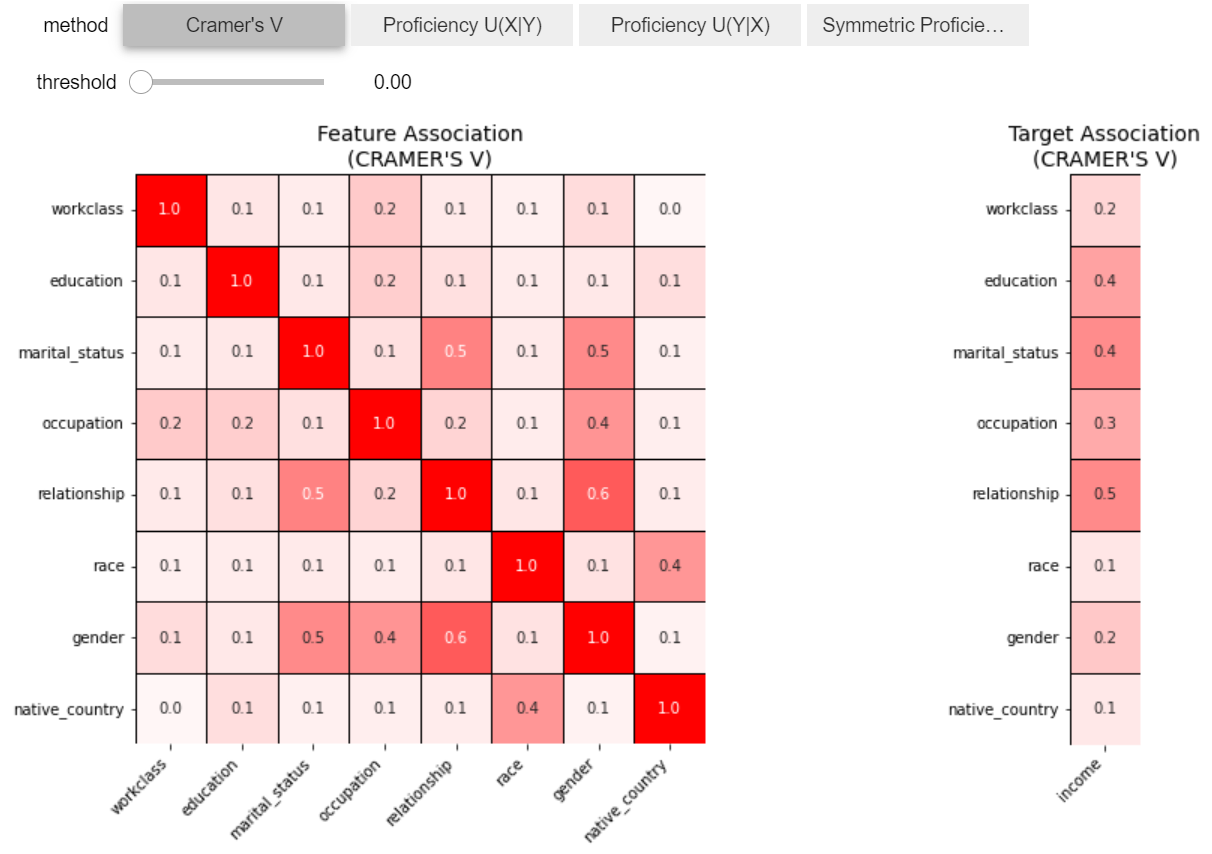

GitHub can't display the plot. Therefore I've captured a picture of it.

## Check Imbalanced Dataset

C:\Users\Malik Afu Hamid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income', ylabel='count'>

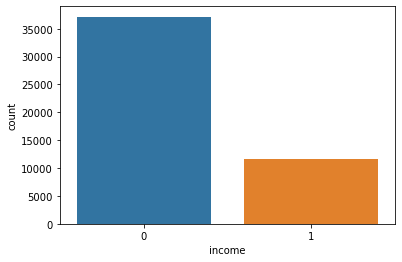

In [34]:
sns.countplot(df.income)

In [35]:
df.income.value_counts()

0    37155
1    11687
Name: income, dtype: int64

`The dataset is slightly balanced. Therefore, I'll use 'accuracy' for the scoring of the model.`

# 4. Dataset Splitting

In [36]:
X = df.drop(columns="income")
y = df.income

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39073, 14), (9769, 14), (39073,), (9769,))

# 5. Modeling

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [38]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['age', 'fnlwgt', 'educational_num', 'capital_gain', 'capital_loss', 'hours_per_week']),
    ('categoric', cat_pipe(encoder='onehot'), ['workclass', 'education', 'marital_status', 'occupation',
                                               'relationship', 'race', 'gender', 'native_country'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, scoring='accuracy', n_iter= 50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


{'algo__C': 0.002231010801867923, 'algo__fit_intercept': False}
0.7980190924679447 0.797967818848337 0.7983416931108609


# 6. Feature Importance

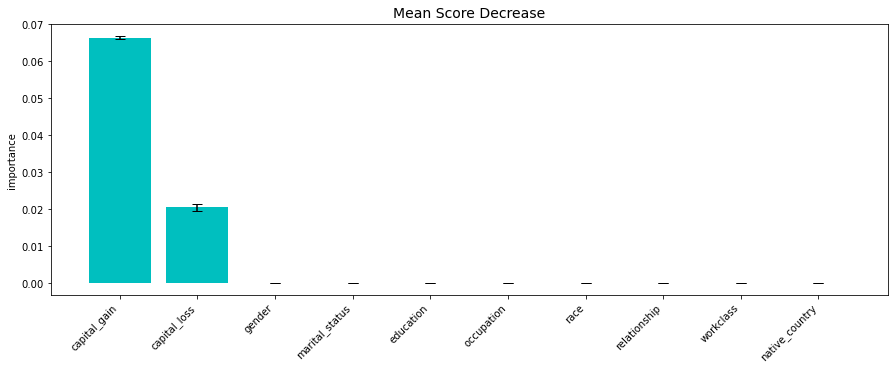

In [39]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   47985 non-null  object
 14  income           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [41]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['capital_gain','capital_loss']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, scoring='accuracy', n_iter= 50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.1s finished


{'algo__C': 0.17670169402947963, 'algo__fit_intercept': True}
0.8132214060860441 0.8110202887410182 0.8132869280376702


# 7. Polynomial Features

In [42]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['capital_gain','capital_loss']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, cv=3, scoring='accuracy', n_iter= 50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.2s finished


{'algo__C': 0.17670169402947963, 'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
0.8132214060860441 0.8110202887410182 0.8132869280376702


# 8. Hyperparameter Tuning

In [43]:
from jcopml.tuning.space import Integer, Real

In [44]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['capital_gain','capital_loss']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

parameter = {'algo__fit_intercept': [True, False],
             'algo__C': Real(low=-2, high=4, prior='log-uniform')}

model = RandomizedSearchCV(pipeline, parameter, cv=3, scoring='accuracy', n_iter= 100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    8.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.0s finished


{'algo__C': 1.7670169402947964, 'algo__fit_intercept': True}
0.8132214060860441 0.8110202887410182 0.8132869280376702


# 9. Evaluation

In [45]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_roc_curve, plot_pr_curve

## 9.1 Classification Report

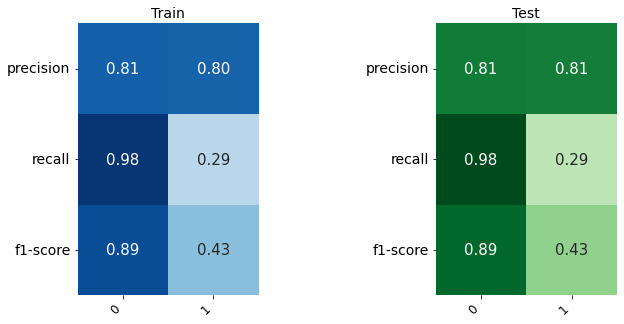

In [46]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

In [47]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     29724
           1       0.80      0.29      0.43      9349

    accuracy                           0.81     39073
   macro avg       0.81      0.63      0.66     39073
weighted avg       0.81      0.81      0.78     39073


Test report
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      7431
           1       0.81      0.29      0.43      2338

    accuracy                           0.81      9769
   macro avg       0.81      0.63      0.66      9769
weighted avg       0.81      0.81      0.78      9769



## 9.2 Precision-Recall Curve

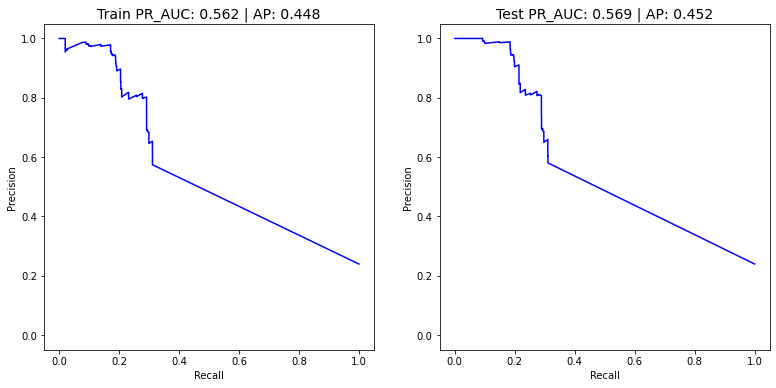

In [48]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

## 9.3 ROC AUC Curve

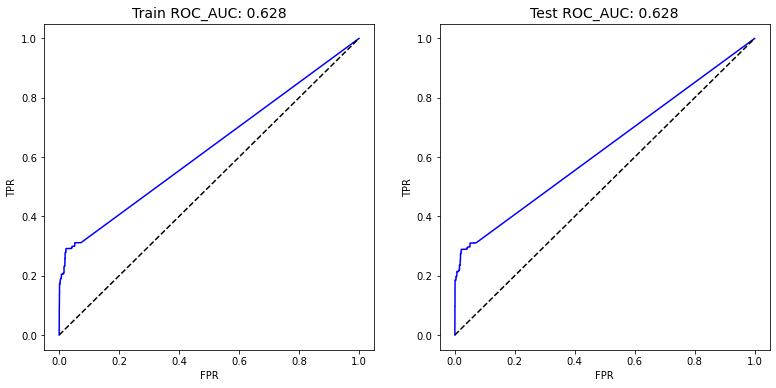

In [49]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

## 9.4 Confusion Matrix

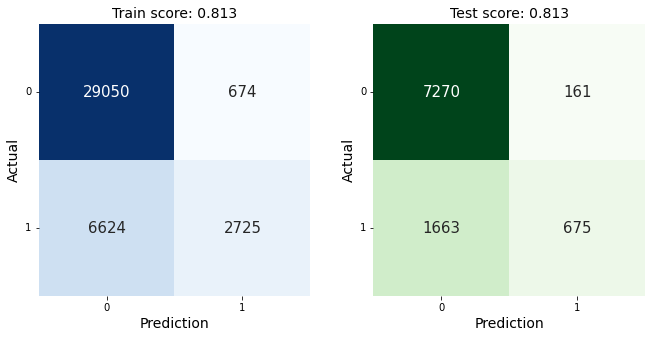

In [50]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Save Model

In [51]:
save_model(model.best_estimator_, 'Income_Classification_logistic_regressor.pkl')

Model is pickled as model/Income_Classification_logistic_regressor.pkl
